In [1]:
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.pipeline import make_pipeline

from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklego.preprocessing import InformationFilter

from fairness import fairestimator
from fairness.blog import utils

np.random.seed(42)

# Ignoring bias for classification problems

This notebook is part of a blog series where I investigate bias in AI.

1. [Introducing the IgnoringEstimator](https://github.com/SjoerdCor/fairness/blob/main/blog/1.IntroducingTheIgnoringEstimator.ipynb) introduced measures of fairness and showed how naive approaches do not solve them, and on the other hand shows how easily the IgnoringEstimator is implemented and solves them well
1. [Dealing with more complex biases](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb) showed how common complex biases are: non-linear, correlated with other attributes and for continuous features, and showed how easy it is to mitigate the disparate treatment with the `IgnoringBiasEstimator`. I also showed how little attention there seems to be for this problem in existing approaches.
1. [Ignoring bias for cassification poblems](https://github.com/SjoerdCor/fairness/blob/main/blog/3.IgnoringBiasForClassificationProblems.ipynb) finally shows how to use the Ignoring Estimator for the classic classification problems - since these are more prolific, we can also compare against a wide variety of existing approaches and see the `IgnoringBiasEstimator` does equally well or better both in terms of bias mitigation and accuracy.



In this installment, I will use the IgnoringBiasClassifier, which eliminates Disparate Treatment for classification problems. Additionally, I will apply a wide variety of other bias mitigation strategies to make a comprehensive comparison, and show that the IgnoringBias does equally well or better both in terms of bias mitigation and accuracy.

We will do so in three simple steps:
1. Create a dataset with whether an employee got a promotion
1. Fit classifiers with a variety of bias mitigation strategies
1. Evaluate remaining bias and accuracy of the classifiers


## Creating the dataset
For the last time in this blog, we stick to the employee situation. Imagine the company now sets out to predict who should be promoted, based on skills. This should only depend on SocialSkills and Education, but in the real world also depends quadratically on age.

<img src="./figures/DGP_classification.PNG" title="The data generating process for salary for an imaginary company with biases in employee salaries"/>

In [3]:
def generate_employees_age(n_employees: int = 2500) -> pd.DataFrame:
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(n_employees),
                       'Education': 4 + 16 * np.random.rand(n_employees),
                       'SocialSkills': np.random.rand(n_employees)
                      }
                     )
        )
    return X

def eligibility_to_promotion(e: float):
    ''' Real number -> 0/1 based on binomial distribution via sigmoid'''
    prob = scipy.special.expit(e)  # Use logistic function to map real number to probability in range [0, 1]
    return np.random.binomial(1, prob) # Turn into yes/no

def add_promotion(df: pd.DataFrame) -> pd.DataFrame:
    weights = {'Age': 0,
               'Education': 0.5,
               'SocialSkills': 2.5,
              }
    error = 0.2
    bias_effect_size = -0.5
    
    base_prob = np.random.normal(-10, error, size=len(df))
    df = df.assign(PromotionEligibilitySkill = lambda df: df.mul(weights).sum('columns').add(base_prob),
                   PromotionEligibilityTrue = lambda df: (df['PromotionEligibilitySkill']
                                                          .add(utils.generate_bias(df['Age'], effect_size=bias_effect_size, power=2))
                                                         ),
                   PromotionSkill = lambda df: df['PromotionEligibilitySkill'].apply(eligibility_to_promotion),
                   PromotionTrue = lambda df: df['PromotionEligibilityTrue'].apply(eligibility_to_promotion),
                  )
    return df

df = generate_employees_age(25000).pipe(add_promotion)

PROTECTED_ATTRIBUTE = ['Age']

In [4]:
utils.display_df(df)

,Age,Education,SocialSkills,PromotionEligibilitySkill,PromotionEligibilityTrue,PromotionSkill,PromotionTrue
6868,48.12,5.41,0.01,-7.31,-6.79,0,0
24016,32.33,16.42,0.32,-1.27,-1.39,1,0
9668,53.25,13.57,0.90,-1.19,-0.91,1,0
13640,45.51,7.79,0.61,-4.45,-3.90,0,0
14018,63.62,15.83,0.75,0.20,-0.68,1,1
7488,48.97,5.16,0.47,-6.20,-5.71,0,1
5804,40.13,18.94,0.21,0.08,0.53,1,0
12909,60.60,7.33,0.46,-5.29,-5.74,0,0
3386,34.74,15.03,0.97,-0.16,-0.05,0,0
9567,60.64,14.87,0.99,0.20,-0.26,0,1


In [5]:
(X_train, X_test,
 y_train, y_test,
 y_skill_train, y_skill_test,
 promotion_eligibility_skill_train, promotion_eligibility_skill_test) = sklearn.model_selection.train_test_split(df.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                                                 df['PromotionTrue'],
                                                                                                                 df['PromotionSkill'],
                                                                                                                 df['PromotionEligibilitySkill'],
                                                                                                                 random_state=42
                                                                                                                 )

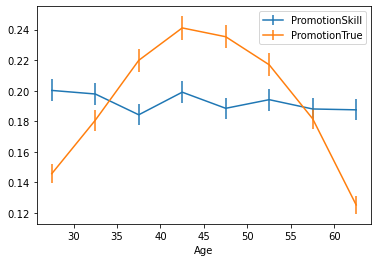

In [6]:
def plot_promotion_prob_by_age(predictions: pd.Series, age: pd.Series, age_group: float = 5, ax=None, **kwargs):
    """
    Plots mean and sem of the promotion probability per age bucket
    
    predictions: columns containing output
    age: coumn containing the age for each prediction
    age_group: bucket size for the age
    ax: pyplot Ax object to which the plot is added. If None, a new Ax is created
    **kwargs are passed to pd.plot method
    """
    if ax is None:
        fig, ax = plt.subplots()
    age_grouped = age // age_group * age_group + age_group/2
    result = predictions.groupby(age_grouped).agg(['mean', 'sem'])
    ax = (result.plot(y='mean', yerr='sem', ax=ax, label=predictions.name, **kwargs))
    return ax
    
ax = plot_promotion_prob_by_age(df['PromotionSkill'], df['Age'])
plot_promotion_prob_by_age(df['PromotionTrue'], df['Age'], ax=ax)
plt.show()

Indeed, the promotions based on skills are independent of age, but in the real world middle-aged people have much higher probability of a promotion

## Calculating the predictions
With the data in hand, we fit models to predict the probability of a promotion. 

We apply a variety of bias mitigation strategies that work with continuos features:
* No bias mitigation strategy, as a baseline
* Preprocessing: InformationFilter, as implemented by `scikit-lego`
* Inprocessing: AdversarialDebiasing, as implemented by `aif360`
* Postprocessing: CalibratedOddsEqualizer, as implemented by `aif360`
* Inprocessing: IgnoringBiasClassifier, as defined within this repository

In [7]:
predictions = {}

In [8]:
def add_predictions_to_results(clf, name: str, predictions: dict = predictions,
                               X_train: pd.DataFrame = X_train, y_train: pd.Series = y_train,
                               X_test: pd.DataFrame = X_test,
                               protected_attribute: str = None) -> None:
    """"
    Helper function that fits a classifier and adds the predictions to an existing dict inplace
    
    clf: the classifier
    name: the name of the strategy, will be key in dictionary
    predictions: the dictionary to which the predictions will be added
    X_train: the features on which the  classifier is trained
    y_train: the target values on which the classifier is trained
    X_test: features of the set to be predicted
    protected_attribute: name of the column(s) of X_train and X_test which are protected if using aif360; then they must 
        be in the index, not in the feature set
    """
    
    if protected_attribute:  # only for aif360
        X_train = X_train.set_index(protected_attribute, append=True)
        X_test = X_test.set_index(protected_attribute, append=True)
        
    clf.fit(X_train, y_train)
    y_pred = utils.predict_series(clf, X=X_test, method='predict_proba')
    
    if protected_attribute:
        y_pred = y_pred.reset_index(protected_attribute, drop=True)  # aif360 adds protected attribute to outcomes as well, but we want identical indices
    predictions[name] = y_pred

In [9]:
rf_kwargs = {'min_samples_leaf': 20, 'random_state': 42}

### No bias mitigation
As a baseline, let's first calculate the naive approach of fitting a model with the protected attribute as a feature, applying no bias mitigation

In [10]:
rf = RandomForestClassifier(**rf_kwargs)
add_predictions_to_results(rf, 'NoBiasMitigation')


### scikit-lego preprocessing: Information Filter
Secondly, let's apply the Information Filter, we also applied in the second part of this series. It tries to transform the dataset in such a way that information about the sensitive column, i.e. Age, is lost. Subsequently, we fit our standard classifer.

In [11]:
clf_information_filter = make_pipeline(InformationFilter(PROTECTED_ATTRIBUTE),
                                       RandomForestClassifier(**rf_kwargs),
                                      )
add_predictions_to_results(clf_information_filter, 'InformationFilter')

### aif360 Inprocessing: Adversarial Debiasing
An interesting inprocessing approach is [Adversarial Debiasing](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.sklearn.inprocessing.AdversarialDebiasing.html#aif360.sklearn.inprocessing.AdversarialDebiasing), where we fit a classifier and its adversary neural network simultaneously; the classifier tries to fit data (promotion from age, social skills and education level) as well as possible, while the adversary tries to estimate the protected column (age) based solely on the probability of promotion. By reducing the ability of the adversary, the classifier can not rely on information from the protected column.

In [12]:
%%time
clf_adv_deb = AdversarialDebiasing(prot_attr=PROTECTED_ATTRIBUTE, adversary_loss_weight=None, random_state=42, classifier_num_hidden_units=64)
add_predictions_to_results(clf_adv_deb, 'AdversarialDebiasing', protected_attribute=PROTECTED_ATTRIBUTE)

Wall time: 4min 57s


### aif360 Postprocessing: CalibratedOddsEqualizer
In this postprocessing scheme, we fit a classifier as if we do not mitigate the bias, but then afterwards we equalize the odds, by e.g. artifically increasing the probability of a certain gender or race.

A great drawback is that this strategy requires binary _groups_, not continuous features, so we must define beforehand who is advantaged and who is disadvantaged. In our case, we make two groups: those middle-aged, between 32.5 and 57.5 years old, and those who are either younger than 32.5 or older than 57.5.

In [13]:
def add_index_to_series(series: pd.Series, index_series: pd.Series) -> pd.Series:
    '''Append index to series.
    
    series: the series to which an index is added
    index_series: the series which is appended as an index
    '''
    
    res = (pd.concat([series, index_series], axis='columns')
           .set_index(index_series.name, append=True)
           .squeeze()
          )
    return res

In [14]:
def dummify(series, low, high):
    """"
    Return series as dummy whether it is in groups
    
    low: minimum threshold value to dummify
    high: maximum threshold value to dummify
    """
    
    return series.between(low, high).astype(int)

In [15]:
# Divide age into two groups: advantaged and disadvantaged, as required to work with CalibratedOddsEqualizer
advantaged_age_group = (32.5, 57.5)

# Add the group as an index to y, as required by aif360
y_train_with_age = y_train.pipe(add_index_to_series, dummify(X_train['Age'], *advantaged_age_group))
y_test_with_age = y_test.pipe(add_index_to_series, dummify(X_test['Age'], *advantaged_age_group))
                              
X_test_grouped_age = X_test.assign(Age = lambda df: dummify(df['Age'], *advantaged_age_group))

In [16]:
clf_postproc = PostProcessingMeta(estimator=RandomForestClassifier(**rf_kwargs),
                                  postprocessor=CalibratedEqualizedOdds(PROTECTED_ATTRIBUTE, random_state=42),
                                  random_state=42)

add_predictions_to_results(clf_postproc, 'CalibratedOddsEqualizer', y_train=y_train_with_age, protected_attribute=PROTECTED_ATTRIBUTE, X_test=X_test_grouped_age)

### Ignoring Bias, from this repository

Finally, of course, we use the IgnoringBiasClassifire from this repository. As a correction strategy we use the "Logitadditive", which is basically the same as the additive method we used in the regression problem, but now applicable for classification problems. We can not just add a constant to probabilities, as that might light lead to probabilities larger than 1, or smaller than 0. Therefore, we first transform the probability to the range (-inf, inf) by using the logit function, add the constant there, and then transform back using the sigmoid function to a probability in the range [0, 1].

In [17]:
ib = fairestimator.IgnoringBiasClassifier(RandomForestClassifier(**rf_kwargs),
                                          ignored_cols=[0], # Ignore the zeroeth column at prediction time -> Age
                                          correction_strategy='Logitadditive')

add_predictions_to_results(ib, 'IgnoringBias')

## Evaluating the different options
### Measuring fairness
We have applied six bias mitigation strategies, and now we can finally visualize the results. We are looking for two twhings:
1. The probability of a promotion should be unbiased, i.e. it should equal for every age group (in this toy dataset skills are independent of age). Just as in [Blog 2](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb), we will use the Mutual Information as a fairness measure.
1. The probability of promotion should be well-calibrated, i.e. the average predicted promotion probability should match the average true promotion probability

In the plot, we see three groups:

* The strongly biased strategy, matching the grey dashed line: the true world biased promotion probabilities
  * Applying No Bias Mitigatoin (blue line) propagates the bias
  * InformationFilter (in orange) mostly unsuccessful in removing the bias: it leaves a linear binas where younger employees are strongly advantaged over older employees.
* The largely unbiased, but badly calibrated strategies
  * AdversialDebiasing (green line) does not exhibit a large bias, but gives everybody a way too low probability of promotion. Perhaps we could improve this with more tweaking, but since it is already very slow and other strategies are succesful out-of-the-box, I decided not to spend more time on this
* The (mostly) successful strategies, closely following the black dahsed line: the promotion probabilities based purely on skill.
  * Postprocessing with the CalibratedOddsEqualizer (red) does very well, which is somewhat surprising given that we had to discretize Age. However, I fear it will not scale well to more complex, continuous biases where we do not know well who is (dis)advantaged beforehand.
  * IgnoringBias (purple) does very well, both on removing bias and calibration

In [18]:
df_predictions = pd.DataFrame(predictions)
df_bias = df_predictions.sub(scipy.special.expit(promotion_eligibility_skill_test), axis=0)

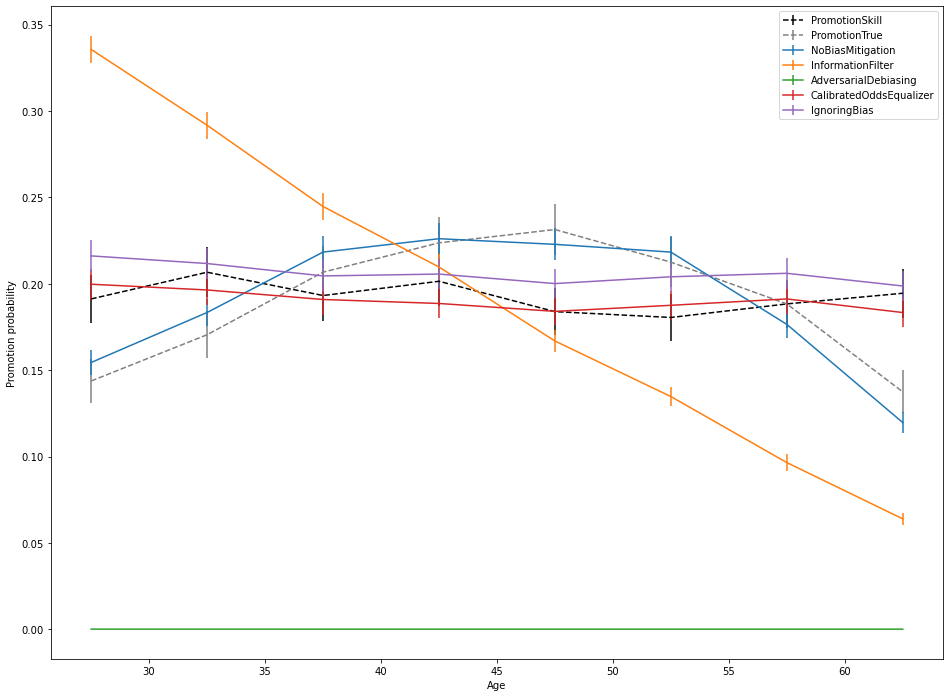

In [19]:
ax = plot_promotion_prob_by_age(y_skill_test, X_test['Age'], figsize=(16, 12), ls='--', c='k')
plot_promotion_prob_by_age(y_test, X_test['Age'], ax=ax, ls='--', c='grey')

for col in df_predictions:
    plot_promotion_prob_by_age(df_predictions[col], X_test['Age'], ax=ax)

ax.set_ylabel('Promotion probability')
plt.show()

In [22]:
%%time 
n_bootstraps = 500
# Boostrapping takes quite a bit of time

# We use a larger number of neigbors for the Mutual Information, since bootstrapping duplicates some samples, and the nearest neighbor is then the sample itself
# With this number, the mean of all the bootstraps matches the non-bootsrapped MI
df_disp_treat = (utils.bootstrap(utils.calculate_mutual_information, pd.concat([df_bias, X_test['Age']], axis='columns'), n_bootstrap= n_bootstraps, n_neighbors=100)
                 .pipe(utils.calculate_bootstrap_confidence_interval)
                )

Wall time: 6min 49s


Finally, we calculate the disparate treatment as the mutual information between the age and the bias , which is the difference between the predicted probability of promtion and the skills-based probability of promotion. Indeed, 3 strategies are (mostly) sucessful in removing the bias, of which the IgnoringBiasEstimator has the best performance.

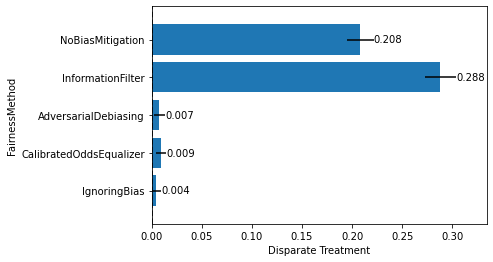

In [23]:
def plot_biases(biases: dict, **kwargs):
    """
    Plot fairness metric with uncertainty for multiple mitigation strategies.

    biases: fairness metrics, dict of dicts structured 
        {"name": {"diff_mean": fairness metric, "diff_sem": uncertainty fairness metric}}
    **kwargs are passed to the DataFrame plot method
    """
    fig, ax = plt.subplots()
    df = pd.DataFrame(biases).transpose()
    p = ax.barh(y=range(len(df)), width=df[0.5], xerr=(df['Uncertainty_lower'], df['Uncertainty_upper']))
    ax.axvline(0, c='k', ls='--')
    plt.yticks(range(len(df)), df.index)
    ax.invert_yaxis()
    ax.set_ylabel('FairnessMethod')
    
    ax.bar_label(p, label_type='edge', fmt='%.3f')
    plt.margins(0.1)  # Make room for the labels
    
    
    return ax

ax = plot_biases(df_disp_treat)
ax.set_xlabel("Disparate Treatment")
plt.show()

### Measuring accuracy
As a measure of the accuracy of the methods, we use [log loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html), which checks both calibration and accuracy.

Four strategies perform almost equally well, of which IgnoringBiasEstimator, again, has the best accuracy. Additionally, it is clear that AdversarialDebiasing does poorly, due to its horrible calibration. 

In [24]:
dummy_logloss = sklearn.metrics.log_loss(y_skill_test, [y_skill_test.mean()] * len(y_skill_test))

In [25]:
accs = df_predictions.apply(lambda col: sklearn.metrics.log_loss(y_skill_test, col))

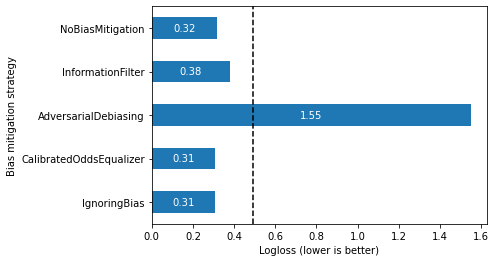

In [26]:
ax = accs.plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.2f', c='white', label_type='center')
ax.axvline(dummy_logloss, c='k', ls='--')
ax.invert_yaxis()
plt.ylabel('Bias mitigation strategy')
plt.xlabel('Logloss (lower is better)')
plt.show()

In [27]:
predictions_train = {}
add_predictions_to_results(rf, 'NoBiasMitigation', X_test=X_train, predictions=predictions_train)
add_predictions_to_results(ib, 'IgnoringBias', X_test=X_train, predictions=predictions_train)

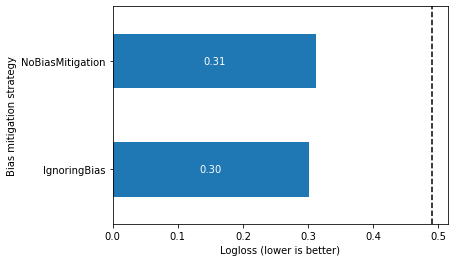

In [28]:
df_predictions_train = pd.DataFrame(predictions_train)
dummy_logloss_train = sklearn.metrics.log_loss(y_skill_test, [y_skill_test.mean()] * len(y_skill_test))

accs = df_predictions_train.apply(lambda col: sklearn.metrics.log_loss(y_skill_train, col))
ax = accs.plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.2f', c='white', label_type='center')
ax.axvline(dummy_logloss_train, c='k', ls='--')
ax.invert_yaxis()
plt.ylabel('Bias mitigation strategy')
plt.xlabel('Logloss (lower is better)')
plt.show()

## Conclusion

In this installment, we saw that for classification problems a wide variety of bias mitigation strategies exist, and that the IgnoringBiasClassifier was best in class both in terms of bias mitigation and accuracy, and arguably in ease-of-use. 

I truly hope the IgnoringBiasEstimator will help mitigate biases in Data Science.